In [1]:
%reload_ext autoreload
%aimport -pandas, -numpy
%autoreload 2
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime, timedelta
from pprint import pprint as pp
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow
from tqdm.auto import tqdm

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSM_splot, FSM_add_Notations, FSM_add_Alarms, FSM_add_Warnings, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left, cvset, load_data, get_cycle_data, get_cycle_data2, figures)
    
cred()
mp = MyPlant(0)
Engine._list_cached_validations();
#mp._fetch_installed_base(); # refresh local installed fleet database

In [2]:
def sfun(x):
    return all([ ("EWB" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
    #return all([ ("Pforzheim" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
    #return all([ ("BMW Landshut 4.10" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

,0,1,2,3
Count_OpHour,25000.0,84280.0,35225.0,35423.0
OperationalCondition,Never Connected,Never Connected,Running,Running
shutdown_counter,NaN,NaN,803.0,1133.0
startup_counter,NaN,NaN,801.0,1134.0
id,25475,108005,108141,108528
Engine Version,B227,E01,F12,F12
Engine Type,620,620,620,620
Engine Series,6,6,6,6
Country,IE,US,DE,DE
Commissioning Date,2011-05-17,2003-09-18,2017-04-11,2017-04-11


In [3]:
motor = fleet.iloc[2]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
e=Engine.from_fleet(mp,motor)
#pp_from=pd.to_datetime(e['Commissioning Date'])
#pp_from=pd.to_datetime('2020-02-01')
#pp_from = pd.to_datetime(e['Commissioning Date']) + timedelta(days=60)
pp_from='2020-02-18 09:50'
pp_to='2020-02-20 07:25'
#pp_to=datetime.now()
#pp_to=pp_from + pd.Timedelta(weeks=8)
fsm = msgFSM(e, p_from=pp_from, p_to=pp_to)
#TODO:
# - move successtime to run1
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success, pp_from, pp_to

('EWB BAUTZEN M01',
 ['???', 'OFF', 'MANUAL', 'AUTO'],
 [True, False],
 '2020-02-18 09:50',
 '2020-02-20 07:25')

In [5]:
fsm.run1_V2(enforce=True, silent=True, successtime=300, debug=False) # run Finite State Machine

In [7]:
fsm.run2(silent = True)

In [8]:
#fsm.store()
#TODO:
# - check in run1 & run2 if changes were made, if not ... do not physically change the stored file

In [10]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
rdb = rda
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")
pd.DataFrame.from_dict(e.dash, orient='index').T

Starts: 1, Successful: 1, Failed: 0 => 100.0%


,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,EWB BAUTZEN M01,M01,T902,620,F12,20,3356.0,22.0,1171430,108141,35268.0,2017-04-11,4128,31140.0,0.094


In [11]:
#rda = rda[rda['count_alarms'] > 0]
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,25.5,4.74,18.04,6.88,18.95,172.33,246.43,2969.9,0.51,163471.12,162.33,60.01,47.21,0,1


In [12]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (16,10)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,200)},
    {'col':['startpreparation'],'_ylim':(-600,900)},
    {'col':['hochlauf'],'_ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    #{'col':['no'],'ylim':(-100,2000),'color':'rgba(0,0,0,0.3)'},
    {'col':['targetload'],'ylim':(500,5000) },
    {'col':['count_warnings','count_alarms','no'],'ylim':(-1,500), 'color':['rgba(255,165,0,0.3)','rgba(255,0,0,0.3)','rgba(0,0,0,0.1)'] }
    ]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, x='datetime', style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)

In [13]:
def f(x=0):
    global vv; vv = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')} CumStart: {startversuch['cumstarttime']:0.1f}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='90%'), max=0), Output()), _dom_…

In [22]:
from localfigures import figures
for f in figures:
    print(f, end=', ')
#for doplot in ['actors','lubrication']:
for doplot in ['actors']:
    dmaxlength = None
    dminlength = None
    #dmaxlength = 1200
    #dminlength = 200000
    dset = figures[doplot]
    vset = cvset(mp,dset)
    startversuch = rdb.iloc[vv]; 
    try:
        data = get_cycle_data2(fsm, startversuch, max_length=dmaxlength, min_length=dminlength, cycletime=1, silent=True, p_data=cvset(mp,dset))
        #data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        warnings.simplefilter('ignore')
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct'],data['time']/1000.0))
        data['BMEP'] = data.apply(lambda x: fsm._e._calc_BMEP(x['Power_PowerAct'] , x['Various_Values_SpeedAct']), axis=1)
        fig = FSM_splot(fsm, startversuch, data, dset, figsize=(16,8))
        fig = FSM_add_Notations(fig, fsm, startversuch)
        fig = FSM_add_Alarms(fig, fsm, startversuch)
        fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    except Exception as err:
        print(err)

starts_overview, actors, lubrication, von: 18.02.2020 09:51:16 bis: 20.02.2020 07:24:23


state,severity,Number,date,message
targetoperation,700,1182,18.02.2020 18:58:59,Measuring signal failure differential pressure engine-room


In [18]:
def xwhere(data,key,level):
    return data.iloc[data['datetime'][1:][np.array(data[key][1:]-level) * np.array(data[key][:-1]-level) < 0].index]

In [19]:
def xwhere2(data,key,level):
    pts = data['datetime'][1:][np.array(data[key][1:]-level) * np.array(data[key][:-1]-level) < 0]
    newlist =[x for p in list(pts.index) for x in [p-1,p]]
    return data.iloc[newlist]

In [20]:
level = 500
pts = data['datetime'][1:][np.array(data['Power_PowerAct'][1:]-level) * np.array(data['Power_PowerAct'][:-1]-level) < 0] #Super Trick!
data.iloc[pts.index]

,time,Various_Values_PosTurboBypass,Various_Values_PosThrottle,TecJet_Lambda1,Various_Values_SpeedAct,Power_PowerAct,Ignition_ITPAvg,datetime
398,1582019575000,100.0,33.729334,1.675407,1500.000000,503.96700,18.0,2020-02-18 09:52:55
7406,1582183345000,100.0,20.922317,1.638552,1499.217054,492.53561,18.0,2020-02-20 07:22:25


In [21]:
xwhere2(data,'Power_PowerAct',500)

,time,Various_Values_PosTurboBypass,Various_Values_PosThrottle,TecJet_Lambda1,Various_Values_SpeedAct,Power_PowerAct,Ignition_ITPAvg,datetime
397,1582019574000,100.0,32.613450,1.676000,1500.000000,489.417000,18.0,2020-02-18 09:52:54
398,1582019575000,100.0,33.729334,1.675407,1500.000000,503.967000,18.0,2020-02-18 09:52:55
7405,1582183344000,100.0,21.452967,1.639978,1499.217054,508.194166,18.0,2020-02-20 07:22:24
7406,1582183345000,100.0,20.922317,1.638552,1499.217054,492.535610,18.0,2020-02-20 07:22:25


In [22]:
xwhere(data,'Various_Values_SpeedAct',50)

,time,Various_Values_PosTurboBypass,Various_Values_PosThrottle,TecJet_Lambda1,Various_Values_SpeedAct,Power_PowerAct,Ignition_ITPAvg,datetime
326,1582019503000,0.0,45.915599,1.1,72.672000,0.0,18.0,2020-02-18 09:51:43
7525,1582183464000,0.0,0.000000,1.1,19.478609,0.0,18.0,2020-02-20 07:24:24


In [24]:
xwhere2(data,'TecJet_Lambda1',1.4)

,time,Various_Values_PosTurboBypass,Various_Values_PosThrottle,TecJet_Lambda1,Various_Values_SpeedAct,Power_PowerAct,Ignition_ITPAvg,datetime
372,1582019549000,100.0000,11.476644,1.317000,1512.197000,0.000000,18.0,2020-02-18 09:52:29
373,1582019550000,99.4186,11.307532,1.431075,1507.998000,11.627000,18.0,2020-02-18 09:52:30
7417,1582183356000,100.0000,16.988789,1.495450,1507.790148,275.672272,18.0,2020-02-20 07:22:36
7418,1582183357000,100.0000,12.127411,1.339000,1548.484724,117.962939,18.0,2020-02-20 07:22:37


# Lastverteilung


Text(0.5, 0, 'Power [kW]')

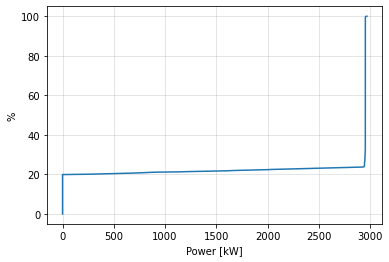

In [35]:
import matplotlib.pyplot as plt
p = data['Power_PowerAct']
N = 1000
y = np.linspace(100,0,N+1)
x = np.percentile(p,y)
plt.plot(x,y)
plt.grid(alpha=0.4)
plt.ylabel('%');
plt.xlabel('Power [kW]')

In [36]:
import bokeh
from bokeh.models import ColumnDataSource, Label, Text, Span, HoverTool #, Range1d#, LabelSet
from bokeh.plotting import figure, output_file, show

#startversuch = rdb.iloc[vvv];
periodfactor = 3 # times calculated period length
helplinefactor = 0.8 # overlay slope to -fac * end value 
#interestingcycles = [0,1,8, 62, 65, 76, 77, 80, 95, 96, 97, 98, 99, 252, 678] # BMW Landshut M4
interestingcycles = [117] # Forsa Hartmoor M1
#interestingcycles = [0,64, 66, 82] # Forsa Hartmoor M4
#interestingcycles = [0] # Pforzheim M4
#interestingcycles = [17] #
#interestingcycles = [335] # !!! Bautzen M01 T902, Start von: 08.12.2021 13:14:29 bis: 12.12.2021 00:40:40
#interestingcycles = [142] # Bautzen M01 T902, Start von: 04.07.2021 15:57:29 bis: 04.07.2021 21:03:40  => Ende nicht erkannt. 
interestingcycles = [vv] # Bautzen M01 T902
disp_result(rdb.iloc[interestingcycles[0]])

no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,targetload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,True,???,25.502999,4.739,18.039,6.877999,18.948999,172.326,246.433997,2969.9,0.513534,163471.119,162.327,60.014999,47.212999,0,1


In [38]:
# Algorithm visualization
import time
import dmyplant2
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
for i in interestingcycles: 
    #startversuch=fsm.results['starts'][i]
    startversuch=rdb.iloc[i]
    sno = startversuch['no']
    data, xmax, ymax, duration, ramprate = dmyplant2.loadramp_edge_detect(fsm,startversuch, periodfactor=periodfactor, helplinefactor=helplinefactor)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        #data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(16,8))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        fig = FSM_add_Alarms(fig, fsm, startversuch)
        fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")

Start:   0 xmax: 2020-02-18 09:55:23, ymax:   2970, duration: 172.3, ramprate: 0.51 %/s
von: 18.02.2020 09:51:16 bis: 20.02.2020 07:24:23


state,severity,Number,date,message
targetoperation,700,1182,18.02.2020 18:58:59,Measuring signal failure differential pressure engine-room


In [39]:
sv=fsm.results['starts'][startversuch['no']]

#phases = [k for k in sv['timing'].keys() if k != 'targetoperation_org']
phases = list(sv['timing'].keys())
fsm._harvest_timings(sv, phases)
sv['loadramp']

172.326

In [43]:
durations = { ph:pd.Timedelta(sv['timing'][ph][-1]['end'] - sv['timing'][ph][-1]['start']).total_seconds() for ph in phases}
durations['cumstarttime'] = sum([v for k,v in durations.items() if k in ['startpreparation','starter','speedup','idle','synchronize','loadramp']])
durations

{'startpreparation': 25.502999,
 'starter': 4.739,
 'speedup': 18.039,
 'idle': 6.877999,
 'synchronize': 18.948999,
 'loadramp': 172.326,
 'targetoperation': 163471.119,
 'rampdown': 162.327,
 'coolrun': 60.014999,
 'runout': 47.212999,
 'targetoperation_org': 163483.445,
 'cumstarttime': 246.433997}

In [45]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

  0 * |0000| LST 18.02 09:51:16 LS  standstill        | CSS 18.02 09:51:16 CS  startpreparation  | off | ???   | 600 18.02.2020 09:51:16 1231 Request module on
  1 * |0001| LST 18.02 09:51:16 LS  startpreparation  | CSS 18.02 09:51:42 CS  starter           | on  | ???   | 600 18.02.2020 09:51:42 1249 Starter on
  2 * |0001| LST 18.02 09:51:42 LS  starter           | CSS 18.02 09:51:46 CS  speedup           | on  | ???   | 600 18.02.2020 09:51:46 3225 Ignition on
  3 * |0001| LST 18.02 09:51:46 LS  speedup           | CSS 18.02 09:52:04 CS  idle              | on  | ???   | 600 18.02.2020 09:52:04 2124 Idle
  4 * |0001| LST 18.02 09:52:04 LS  idle              | CSS 18.02 09:52:11 CS  synchronize       | on  | ???   | 600 18.02.2020 09:52:11 2139 Request Synchronization
  5 * |0001| LST 18.02 09:52:11 LS  synchronize       | CSS 18.02 09:52:30 CS  loadramp          | on  | ???   | 600 18.02.2020 09:52:30 1235 Generator CB closed
  6 * |0001| LST 18.02 09:52:30 LS  loadramp          | CS

In [46]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=False)):
    print(f"{i:3} {v}")

  0 * |0000| LST 18.02 09:51:16 LS  standstill        | CSS 18.02 09:51:16 CS  startpreparation  | off | ???   | 600 18.02.2020 09:51:16 1231 Request module on
  1   |0001| LST 18.02 09:51:16 LS  standstill        | CSS 18.02 09:51:16 CS  startpreparation  | on  | ???   | 600 18.02.2020 09:51:16 3237 Engine operation without heating pump
  2 * |0001| LST 18.02 09:51:16 LS  startpreparation  | CSS 18.02 09:51:42 CS  starter           | on  | ???   | 600 18.02.2020 09:51:42 1249 Starter on
  3 * |0001| LST 18.02 09:51:42 LS  starter           | CSS 18.02 09:51:46 CS  speedup           | on  | ???   | 600 18.02.2020 09:51:46 3225 Ignition on
  4   |0001| LST 18.02 09:51:42 LS  starter           | CSS 18.02 09:51:46 CS  speedup           | on  | ???   | 600 18.02.2020 09:51:55 1250 Starter off
  5 * |0001| LST 18.02 09:51:46 LS  speedup           | CSS 18.02 09:52:04 CS  idle              | on  | ???   | 600 18.02.2020 09:52:04 2124 Idle
  6   |0001| LST 18.02 09:51:46 LS  speedup         

,startpreparation,speedup,idle,synchronize,loadramp,targetload,ramprate,cumstarttime,targetoperation,rampdown,coolrun,runout
count,1.0,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
mean,25.5,18.04,6.88,18.95,172.33,2969.9,0.51,246.43,163471.12,162.33,60.01,47.21
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,25.5,18.04,6.88,18.95,172.33,2969.9,0.51,246.43,163471.12,162.33,60.01,47.21
25%,25.5,18.04,6.88,18.95,172.33,2969.9,0.51,246.43,163471.12,162.33,60.01,47.21
50%,25.5,18.04,6.88,18.95,172.33,2969.9,0.51,246.43,163471.12,162.33,60.01,47.21
75%,25.5,18.04,6.88,18.95,172.33,2969.9,0.51,246.43,163471.12,162.33,60.01,47.21
max,25.5,18.04,6.88,18.95,172.33,2969.9,0.51,246.43,163471.12,162.33,60.01,47.21


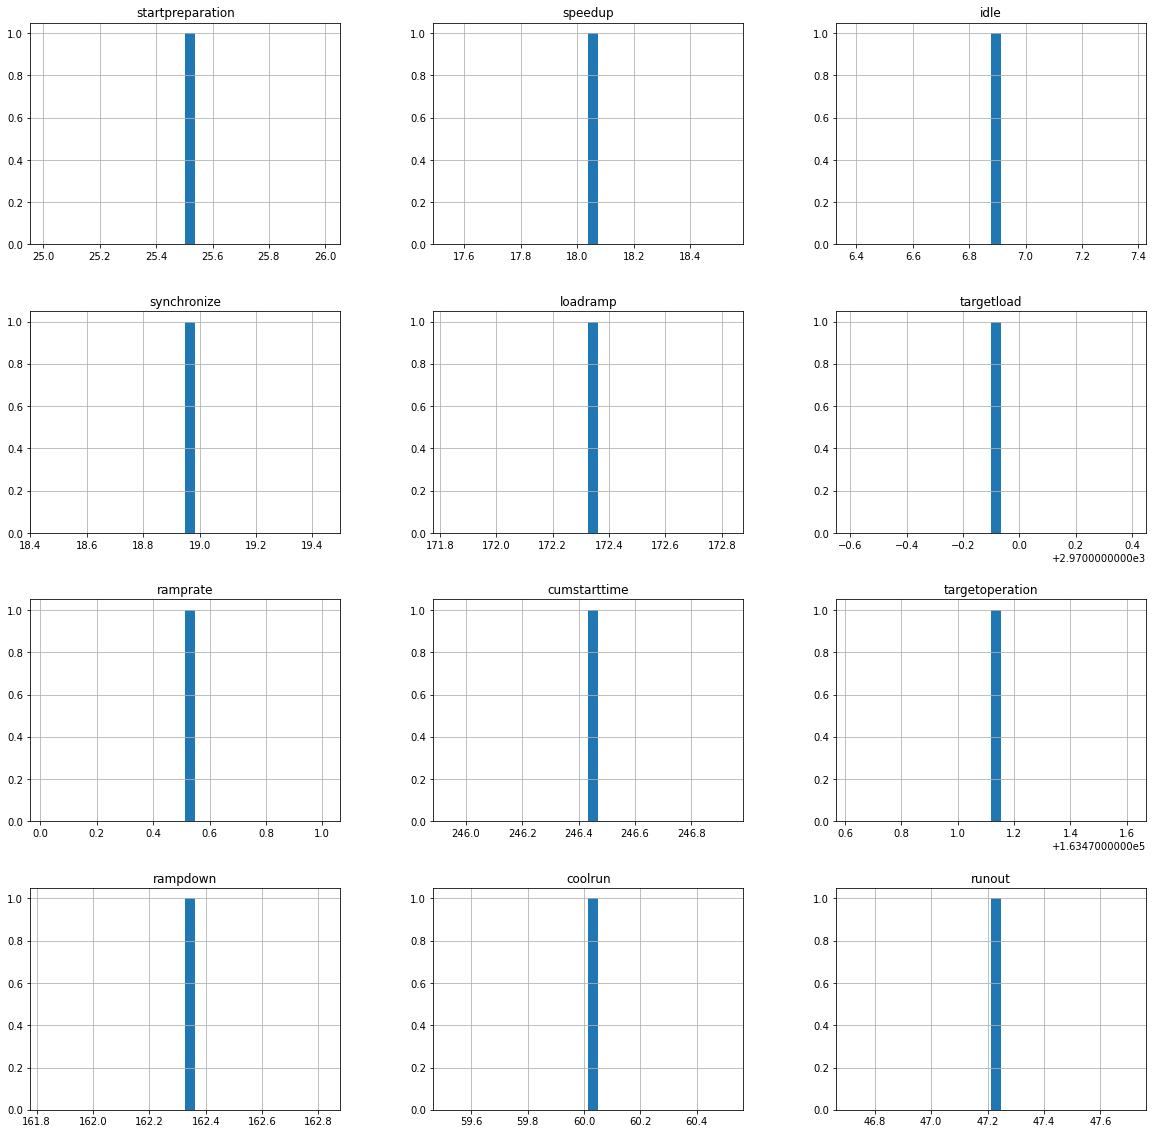

In [47]:
rdb = rda
vec = ['startpreparation','speedup','idle','synchronize','loadramp','targetload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [48]:
import time
dset2 = [{'col':['Power_PowerAct','helpline'], 'ylim':(-1000,12000), 'color':['red','rgba(0,128,0,0.2)'], 'unit':'kW'},
         {'col':['power_diff','power_diff_help'], '_ylim':(0,5000), 'color':['rgba(255,0,0,0.2)','rgba(0,128,0,0.2)'], 'unit':'kW/s'}]
ratedload = fsm._e['Power_PowerNominal']
t0 = time.time()
for i, startversuch in rdb[-3:].iterrows() : 
#for i, startversuch in tqdm(rdb.iterrows(), total=rdb.shape[0], ncols=80, mininterval=1, unit=' starts', desc="FSM Run2"):
    data, xmax, ymax, duration, ramprate = dmyplant2.loadramp_edge_detect(fsm,startversuch)
    if not data.empty:
        print(f"Start: {startversuch['no']:3d} xmax: {xmax}, ymax: {ymax:6.0f}, duration: {duration:5.1f}, ramprate: {ramprate / ratedload * 100.0:4.2f} %/s")
        data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
        #data['power_diff_help'] = pd.Series(np.gradient(data['helpline']))
        fig = FSM_splot(fsm, startversuch, data, dset2, figsize=(14,6))
        fig.add_layout(Span(location=0.0,dimension='width',x_range_name='default', y_range_name='0',line_color='black', line_dash='solid', line_alpha=0.4)) 
        fig.add_layout(Span(location=ymax,dimension='width',x_range_name='default', y_range_name='0',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig.add_layout(Span(location=xmax,dimension='height',line_color='blueviolet', line_dash='dashdot', line_alpha=0.4, line_width=2)) 
        fig = FSM_add_Notations(fig, fsm, startversuch)
        #fig = FSM_add_Alarms(fig, fsm, startversuch)
        #fig = FSM_add_Warnings(fig, fsm, startversuch)
        bokeh_show(fig)
    else:
        print(f"Start: {startversuch['no']:3d} no data, no improvement possible.")
t1 = time.time()
print(f"{(t1-t0):4.1f} sec")    

Start:   0 xmax: 2020-02-18 09:55:23, ymax:   2970, duration: 172.3, ramprate: 0.51 %/s
von: 18.02.2020 09:51:16 bis: 20.02.2020 07:24:23


 0.3 sec


In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)